In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../CommonUtils/') # https://github.com/glukicov/EDMTracking/tree/master/CommonUtils
import CommonUtils as cu
font_size=16

In [4]:
data = pd.read_csv("../DATA/misc/scans/scan.csv")
par_n=-1
if(data.shape[1] == 27):  par_n=10
if(data.shape[1] == 25):  par_n=9
if(data.shape[1] == 17):  par_n=5
print("par_n =", par_n, "according to expected total columns")
# data.info()

par_n = 10 according to expected total columns


In [5]:
# iterators
stations=(12, 18)
dss = ("60h", "9D", "HK", "EG")

In [18]:
#iterative cuts
station=stations[0]
ds=dss[0]

In [19]:
# apply cuts and select data
station_cut = (data["station"]==station)
ds_cut =  (data['ds']==ds)
plot_data= data[station_cut & ds_cut]
# plot_data=plot_data[plot_data['chi2']<1.08]
plot_data=plot_data.reset_index()

In [20]:
# resolve paramters for plotting 
start=plot_data['start']
stop=plot_data['stop']
chi2 = plot_data['chi2']
chi2_e=np.sqrt(2/ (plot_data['ndf']-par_n) )

In [21]:
# get for plotting
x=start
y=chi2
y_e=chi2_e 
y_s = np.sqrt(y_e**2-y_e[0]**2) # 1sigma band

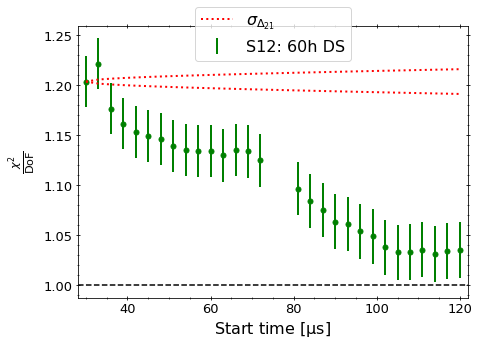

In [22]:
fig, ax = cu.plot(x, y, y_err=y_e, error=True, elw=2, label="S"+str(station)+": "+ds+" DS")
ax.plot(x, y, marker=".", ms=10, c="g", lw=0)
ax.plot(x, y[0]+y_s, c="r", ls=":", lw=2, label=r"$\sigma_{\Delta_{21}}$")
ax.plot(x, y[0]-y_s, c="r", ls=":", lw=2)
ax.plot([min(x)-2, max(x)+2], [1, 1], c="k", ls="--")
ax.set_xlim(min(x)-2, max(x)+2)
ax.set_xlabel(r"Start time [$\rm{\mu}$s]", fontsize=font_size);
ax.set_ylabel(r"$\frac{\chi^2}{\rm{DoF}}$", fontsize=font_size);
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1))
fig.savefig("../fig/start_chi2.png", dpi=300)

In [16]:
y=plot_data['tau']
y_e=plot_data['tau_e']
y_s = np.sqrt(y_e**2-y_e[0]**2) # 1sigma band

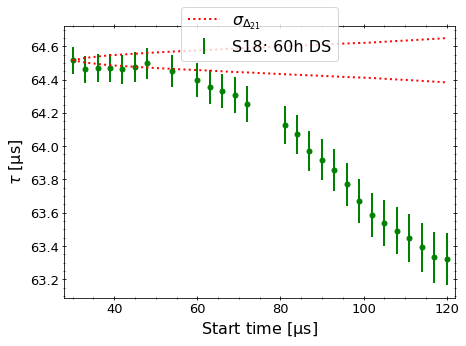

In [17]:
fig, ax = cu.plot(x, y, y_err=y_e, error=True, elw=2, label="S"+str(station)+": "+ds+" DS")
ax.plot(x, y, marker=".", ms=10, c="g", lw=0)
ax.plot(x, y[0]+y_s, c="r", ls=":", lw=2, label=r"$\sigma_{\Delta_{21}}$")
ax.plot(x, y[0]-y_s, c="r", ls=":", lw=2)
# ax.plot([min(x)-2, max(x)+2], [1, 1], c="k", ls="--")
ax.set_xlim(min(x)-2, max(x)+2)
ax.set_xlabel(r"Start time [$\rm{\mu}$s]", fontsize=font_size);
ax.set_ylabel(r"$\tau$ [$\rm{\mu}$s]", fontsize=font_size);
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1))
fig.savefig("../fig/start_LT.png", dpi=300)